# Project Data Analytics - Crab length prediction and correlation analysis

Authors: Daniel Sędłak, Kinga Brudz


Date: 09-07-2023

# 1. Problem formulation
Crabs are crustaceans belonging to the order Decapoda, known for their distinctive appearance. They are widely distributed in oceans around the world, occurring in both saltwater and freshwater environments. Crabs have a hard exoskeleton, segmented body and five pairs of legs, the front pair of which are usually modified into claws.
Crabs play an important ecological role as scavengers and predators, contributing to the balance of marine ecosystems. In addition to their ecological importance, crabs have long been valued for their culinary appeal and are a popular seafood delicacy in many cultures. Because of their economic and gastronomic value, crab farming has gained importance as a profitable aquaculture venture. Crab farming involves raising crabs in controlled environments, providing optimal conditions for their growth and development. It offers benefits such as low labor costs, relatively lower production costs and rapid growth rates compared to other aquaculture practices.

The main goal of the project is to determine the correlation between crab length and shell weight. The length of a crab is a key indicator of its size and maturity, while shell weight reflects the weight and thickness of the outer protective shell. By studying the correlation between these two attributes, scientists and crab farmers can gain insight into the physical characteristics and health of crabs. Analyzing the correlation between length and shell weight can help identify patterns and trends in crab growth.  Understanding the correlation between length and shell weight is valuable for a variety of purposes. For commercial crab farmers, it can help determine the optimal size at which crabs should be harvested for maximum profitability. It can also help assess the overall quality and market value of crabs, since crabs with well-developed shells relative to their length are often preferred by consumers.
Scientists studying crab populations and ecosystems can use this correlation to assess the health and growth patterns of crab populations in different habitats. By monitoring changes in shell length and weight over time, they can gain insight into how environmental factors, such as food availability and water quality, affect crab growth.

The data is sourced from: https://www.kaggle.com/datasets/sidhus/crab-age-prediction. The dataset was collected from crabs farmed in Boston during the years 2018-2019 and includes information such as gender, length, diameter, height, weight, shucked weight, viscera weight, shell weight, and age.
In the Massachusetts Bay region, where Boston is located, crab farming primarily focuses on two species: the Blue Crab (Callinectes sapidus) and the American Lobster (Homarus americanus).


Graph created based on dataset before proccessing.

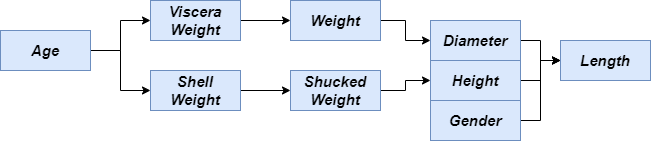

When analyzing these data, possible confoundings may include factors such as:

- Age of the crabs: If we are studying the relationship between two variables, such as length and shell weight, then differences in the age of the crabs may affect this relationship. Older crabs may have greater shell length and weight, regardless of any other factors.
- Gender of crabs: The gender of crabs may be another factor affecting the relationship between length and shell weight. If only one gender of crabs is studied, differences due to gender may lead to distortions in the analysis.
- Living environment: Environmental conditions such as temperature, food availability, water salinity, etc., can affect both the length and weight of crabs' shells. If different groups of crabs live in different environments, this can lead to distortions in the analysis.

# 2. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from cmdstanpy import CmdStanModel
import scipy.stats as stats
import arviz as az

# from DA_tools import ribbon_plot
# from DA_colors import *

from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CrabAgePrediction = pd.read_csv("CrabAgePrediction.csv")

### Data description </span>
* Sex - Gender of the Crab - Male, Female and Indeterminate.
* Length - Length of the Crab (in Feet; 1 foot = 30.48 cms)
* Diameter - Diameter of the Crab (in Feet; 1 foot = 30.48 cms)
* Height - Height of the Crab (in Feet; 1 foot = 30.48 cms)
* Weight - Weight of the Crab (in ounces; 1 Pound = 16 ounces)
* Shucked Weight - Weight without the shell (in ounces; 1 Pound = 16 ounces = 0.45 kg)
* Viscera Weight - is weight that wraps around your abdominal organs deep inside body (in ounces; 1 Pound = 16 ounces)
* Shell Weight - Weight of the Shell (in ounces; 1 Pound = 16 ounces)
* Age - Age of the Crab (in months)

In [3]:
CrabAgePrediction.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [4]:
if CrabAgePrediction.isnull().values.any(): print("Empty data found.")
else: print("Empty data not found.")

Empty data not found.


In [5]:
CrabAgePrediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


The analysis included only crabs aged 12 months and older. This age threshold was chosen because around this time, a crab is considered to be an adult. Selecting this age allows for a focused examination of the adult crab population and eliminates potential influences from younger individuals on the analysis outcomes.

Additionally, to ensure consistency and mitigate the influence of gender differences on the analyzed results, data pertaining only to male individuals was selected. By excluding data related to females and individuals with indeterminate gender, variables can be controlled, and potential confounding factors arising from gender disparities can be eliminated. This approach enables a focused examination of a specific aspect of the study, reducing the impact of other factors on the analysis outcomes.

Before conducting the analysis, the dataset was checked for missing data and data types to ensure data quality and reliability.

In [6]:
CrabAgePrediction_1 = CrabAgePrediction.drop(CrabAgePrediction[(CrabAgePrediction['Sex'] == 'F') | (CrabAgePrediction['Sex'] == 'I')].index)
CrabAgePrediction_1 = CrabAgePrediction_1[CrabAgePrediction_1['Age'] >= 12]

COUNT  = CrabAgePrediction_1.loc[CrabAgePrediction['Sex'] == 'M'].shape[0]
print(COUNT)
CrabAgePrediction_1.head()

408


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
25,M,1.2625,1.0000,0.3875,23.856104,7.696889,5.032036,8.079607,12
27,M,1.5250,1.2125,0.4375,35.280953,15.422128,8.419802,9.780577,12
34,M,1.5500,1.2250,0.4750,34.529691,15.464652,8.405627,10.064072,13
65,M,1.3125,1.0375,0.4000,18.271253,7.370870,4.465046,6.236890,12
72,M,0.8750,0.6375,0.2125,6.080968,2.834950,1.318252,1.700970,13


In [7]:
CrabAgePrediction_1.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,1.481893,1.168536,0.414461,32.928431,13.255233,6.971684,10.044165,14.463235
std,0.197643,0.162824,0.073013,13.341423,6.326493,2.952183,3.780261,2.678263
min,0.875000,0.637500,0.200000,5.032036,1.630096,1.190679,1.700970,12.000000
25%,1.350000,1.050000,0.362500,23.774599,8.657229,4.886745,7.370870,12.000000
50%,1.487500,1.175000,0.412500,31.106489,12.027275,6.477861,9.589218,14.000000
75%,1.612500,1.287500,0.462500,40.695707,16.393098,8.579267,12.190285,16.000000
max,1.937500,1.575000,0.625000,80.101512,38.300174,21.545620,25.429502,27.000000


In [8]:
CrabAgePrediction_1['Length'].describe()

count    408.000000
mean       1.481893
std        0.197643
min        0.875000
25%        1.350000
50%        1.487500
75%        1.612500
max        1.937500
Name: Length, dtype: float64

In [9]:
CrabAgePrediction_1['Shell Weight'].describe()

count    408.000000
mean      10.044165
std        3.780261
min        1.700970
25%        7.370870
50%        9.589218
75%       12.190285
max       25.429502
Name: Shell Weight, dtype: float64

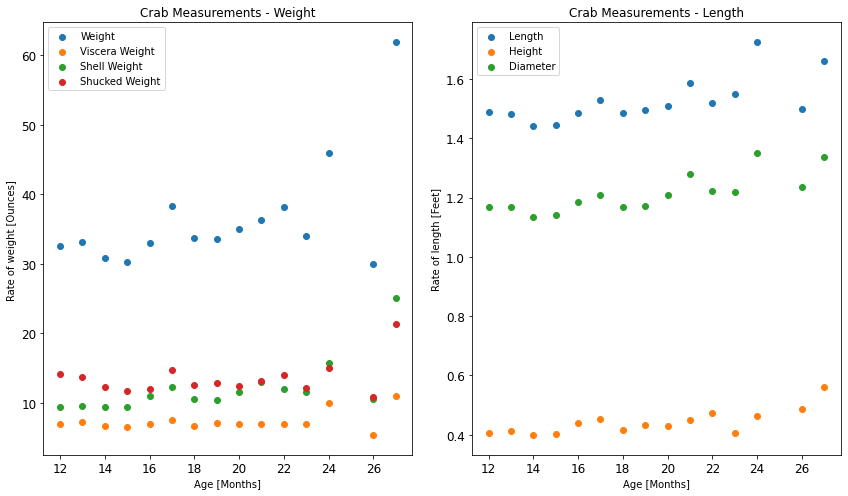

In [10]:
df_grouped = CrabAgePrediction_1.groupby("Age").mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

ax1.scatter(df_grouped["Age"], df_grouped["Weight"], label="Weight")
ax1.scatter(df_grouped["Age"], df_grouped["Viscera Weight"], label="Viscera Weight")
ax1.scatter(df_grouped["Age"], df_grouped["Shell Weight"], label="Shell Weight")
ax1.scatter(df_grouped["Age"], df_grouped["Shucked Weight"], label="Shucked Weight")

ax2.scatter(df_grouped["Age"], df_grouped["Length"], label="Length")
ax2.scatter(df_grouped["Age"], df_grouped["Height"], label="Height")
ax2.scatter(df_grouped["Age"], df_grouped["Diameter"], label="Diameter")

ax1.set_title("Crab Measurements - Weight")
ax2.set_title("Crab Measurements - Length")

ax1.set_xlabel("Age [Months]", fontsize=10)
ax1.set_ylabel("Rate of weight [Ounces] ", fontsize=10)
ax2.set_xlabel("Age [Months]", fontsize=10)
ax2.set_ylabel("Rate of length [Feet]", fontsize=10)

ax1.legend()
ax2.legend()


ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()


Separating the plots for weight and length was done because weight and length variables can have different value ranges, which can lead to difficulties in comparing them on a single plot. By creating separate plots, we can better compare the trends and changes for each variable independently. This approach allows for a clearer understanding of the characteristics of crab weight and length, while avoiding issues with comparing data of different scales on a single plot. Ultimately, with individual plots, we can focus on specific aspects of each variable and easily interpret information related to crab weight and length.

Based on the plotted graphs:

Weight Trend: The scatter plot for weight shows a generally increasing trend with age. As crabs grow older, their weight tends to increase. This indicates that weight is positively correlated with age.

Length Trend: The scatter plot for length does not show a clear trend with age. The data points are scattered and do not exhibit a consistent pattern of change. This suggests that length may not be strongly influenced by age alone.

Weight Variability: The scatter plot for weight also reveals a significant amount of variability in weight values for each age group. There is a wide spread of data points, indicating that factors other than age may contribute to the variation in weight among crabs.

Outliers: In both plots, there are a few outlier data points that deviate from the general trend. These outliers may represent crabs with unusual characteristics or measurement errors. Overall, the weight plot provides more meaningful insights into the relationship between weight and age compared to the length plot. The variability in weight suggests that factors beyond age alone influence crab weight. Moreover genetics and seasonality are factors that can have an impact on the observed results. Individual genetic differences among crabs can influence their growth and development, leading to variations in size and weight regardless of age. Additionally, seasonality plays a significant role in the growth and development of crabs. During periods of intense reproduction or migration, crabs may exhibit altered growth patterns and weight changes.

# 3. Model

- `Model 1:`

To begin with, a first model of the normal distribution was created, which is expressed by the formula:

$$ {Normal}(μ, σ) $$

The mean (μ) is the central value of the distribution and is where the distribution is most likely to be found. It represents the expected value or the "center" of the distribution. The standard deviation (σ), on the other hand, is a measure of the spread or variability of the data points around the mean. The greater the standard deviation, the wider the spread of values, and the data are more spread out from the mean.

In the context of crabs, the Normal(μ, σ) model could be used to analyze and predict the distribution of crab lengths in a population. Here, the mean (μ) would represent the average crab length in a given population. This is the length that we would expect to see most frequently when measuring a large number of crabs from the same population.

The standard deviation (σ), on the other hand, would signify the variability or dispersion in crab lengths within this population. A smaller standard deviation would suggest that most crabs have lengths close to the mean, indicating a closely-knit population with minimal size differences. A larger standard deviation would imply that the lengths of the crabs vary more widely from the mean, suggesting a more diverse population in terms of size.

- `Model 2:`

A second model with a linear distribution was then created, which is expressed by the formula:

$$ y\sim \mathrm{Normal}(\alpha + X\beta, \sigma) $$

In this linear model, the length of the crab (y) is predicted from the shell weight rate (X), using a normal distribution. The shell weight rate is treated as the predictor or independent variable in the model, while the crab length is the dependent variable that we're trying to predict.

The α term in the model represents the intercept, which in this case is the estimated crab length when the shell weight rate is zero. The β term is the slope of the line, representing the expected change in the crab length for each unit increase in the shell weight rate. It quantifies the strength and direction of the relationship between the shell weight and the crab length.

The σ is again the standard deviation, providing a measure of the variability or dispersion of the crab lengths around the line defined by α + Xβ.

- `Difference between models:`

The first model utilizes a simple normal distribution formula, while the second model incorporates a linear regression formula. The first model aims to represent the overall distribution of the data using the mean and standard deviation parameters. It provides a general understanding of the data distribution. In contrast, the second model specifically focuses on analyzing the relationship between the crab length rate and the shell weight rate. It uses a linear regression approach to predict the crab length rate based on the shell weight rate.
The first model requires the basic dataset without any specific predictor variables. It aims to capture the overall characteristics of the data distribution. On the other hand, the second model requires both the crab length rate and the shell weight rate as predictor variables to establish the linear relationship.

# 4. Normal Model 1 - Prior predictive check

Prior parameters information where selected from the article https://swinomish-nsn.gov/media/71736/20180618_final_crablwreport.pdf?fbclid=IwAR3ChCtjECTrEiGVF8boJpX_jrZoMjPYn9lNzvDw-CskXQrFsAf7U8mdMVs was used to create the model.

The parameters used in the model, namely the mean (`μ`) and standard deviation (`σ`), were carefully determined based on thorough research and scrutiny to ensure their validity and relevance. In this case, the mean value was set to 1.46, while the standard deviation was set to 0.21.

However, it is important to acknowledge that these parameter values may deviate from the true population values. To account for this uncertainty and variability, an additional measure was introduced. Specifically, an uncertainty factor of 4.76 (corresponding to 1 divided by the standard deviation) was incorporated into the model. This uncertainty factor allows for a range of potential values and acknowledges the inherent variability in the data.

By considering and incorporating this uncertainty, the model becomes more robust and flexible, accommodating potential variations and deviations from the expected mean and standard deviation values. This approach enables a more comprehensive and realistic representation of the underlying distribution and provides a more accurate framework for analyzing and interpreting the data.

In [11]:
normal_model1 = CmdStanModel(stan_file = 'normal_ppc.stan')

R = 1000
sim_normal = normal_model1.sample(iter_sampling = R,
                                  iter_warmup = 0,
                                  chains = 1,
                                  fixed_param = True,
                                  seed = 31052023)

mu_normal_ppc = sim_normal.stan_variable('mu')
sigma_normal_ppc = sim_normal.stan_variable('sigma')
length_normal_ppc = sim_normal.stan_variable('length')

19:31:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


19:31:06 - cmdstanpy - INFO - CmdStan done processing.


### Plot histogram of mean, standard deviation and simulated length rate from the prior

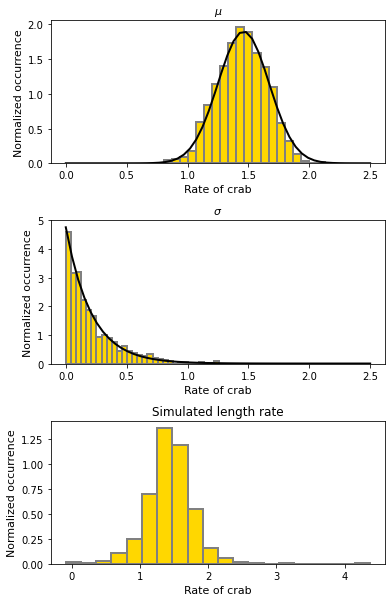

In [12]:
fig, axes = plt.subplots(3,1, figsize=(6, 10))

axes[0].hist(mu_normal_ppc, bins=20, density=True, color = 'gold', edgecolor='grey', linewidth=2)
x = np.linspace(0, 2.5)
y = stats.norm.pdf(x, loc = 1.46, scale = 0.21)
axes[0].plot(x, y, color = 'black', linewidth =2)
axes[0].set_title('$\mu$', fontsize = 11)
axes[0].set_xlabel('Rate of crab', fontsize = 11)
axes[0].set_ylabel('Normalized occurrence', fontsize = 11)

axes[1].hist(sigma_normal_ppc, bins=30, density=True, color = 'gold', edgecolor='grey',linewidth=2)
x = np.linspace(0, 2.5)
y = stats.expon.pdf(x, scale = 0.21)
axes[1].plot(x, y, color = 'black',linewidth =2)
axes[1].set_title('$\sigma$', fontsize = 11)
axes[1].set_xlabel('Rate of crab', fontsize = 11)
axes[1].set_ylabel('Normalized occurrence', fontsize = 11)

axes[2].hist(length_normal_ppc, bins=20,density=True, color = 'gold', edgecolor='grey',linewidth=2)
axes[2].set_title('Simulated length rate')
axes[2].set_xlabel('Rate of crab', fontsize = 11)
axes[2].set_ylabel('Normalized occurrence', fontsize = 11)

plt.subplots_adjust(hspace = 0.4)
plt.show()


The graphs vividly depict the juxtaposition between the observed distributions of mean and standard deviation and their corresponding counterparts derived from the prior model. The alignment of the `μ` values with the normal model distribution present in the dataset is truly striking, indicating a strong agreement between the prior model and the actual data. Similarly, the `σ` values exhibit a consistent pattern reminiscent of an exponential function, further reinforcing the coherence of the prior model.

The measurements simulated from the priors not only align with the expected patterns but also make logical sense in the context of the analyzed phenomenon. This coherence between the simulated measurements and the underlying priors enhances our confidence in the suitability and validity of the model for further analysis and inference.

### Plot histogram comparing the prior and the actual data

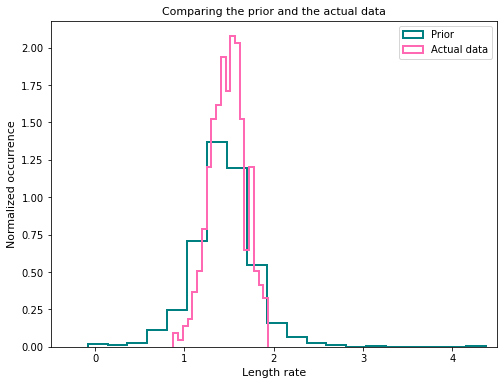

In [13]:
fig, axes = plt.subplots(1,1,figsize=(8, 6))

axes.hist(length_normal_ppc, bins=20, label= "Prior", histtype='step',color='teal' ,density = True, linewidth =2)
axes.hist(CrabAgePrediction_1['Length'],bins=20, label= "Actual data",
          histtype='step', color= 'hotpink', density = True, linewidth =2)

plt.title('Comparing the prior and the actual data', fontsize = 11)
plt.xlabel('Length rate', fontsize = 11)
plt.ylabel('Normalized occurrence', fontsize = 11)
plt.xlim([-0.5,4.5])

plt.legend()
plt.show()

The prior model showcases a strong adherence to the actual data, as it encompasses the full range of observed values. However, it's worth noting that the prior extends into negative values, which is not feasible in the context of length measurements. This discrepancy will be rectified in subsequent models to ensure accurate representation.

# 5. Normal model 1 - Posterior analysis

A normal distribution model was made with fitting.

In [14]:
fit_model1 = CmdStanModel(stan_file = 'normal_fit.stan')
stan_data={"N": len(CrabAgePrediction_1), "lengths": CrabAgePrediction_1['Length']}

R = 1000
sim_fit = fit_model1.sample(data = stan_data, iter_sampling = R,
                            iter_warmup = 1000,
                            chains = 4,
                            fixed_param = False,
                            seed = 31052023)

mu_normal_fit = sim_fit.stan_variable('mu')
sigma_normal_fit = sim_fit.stan_variable('sigma')
length_normal_fit = sim_fit.stan_variable('length')


19:31:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:31:07 - cmdstanpy - INFO - CmdStan done processing.


This Bayesian model estimates the parameters `μ` and `σ` based on available data regarding crab length. It utilizes prior normal and exponential distributions for these parameters. Subsequently, it fits a normal distribution to the data, taking into account these estimated parameters. Finally, it generates log-likelihood values for each observation and a random value for crab length based on the estimated parameters.
After compilation of the normal distribution model with fitting, there were no sampling errors.

In [15]:
sim_fit.diagnose()

'Processing csv files: /tmp/tmpjpb0fd04/normal_fituewjduqe/normal_fit-20230709193107_1.csv, /tmp/tmpjpb0fd04/normal_fituewjduqe/normal_fit-20230709193107_2.csv, /tmp/tmpjpb0fd04/normal_fituewjduqe/normal_fit-20230709193107_3.csv, /tmp/tmpjpb0fd04/normal_fituewjduqe/normal_fit-20230709193107_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [16]:
az.summary(sim_fit,var_names=['mu','sigma','length'], round_to=5,kind='stats')
# The code az.summary(sim_fit,var_names=['mu','sigma','length'], round_to=5,kind='stats') calculates and displays summary statistics for the variables 'mu', 'sigma', and 'length' based on the posterior samples stored in sim_fit.

,mean,sd,hdi_3%,hdi_97%
mu,1.48154,0.00981,1.46201,1.49857
sigma,0.19788,0.00676,0.18528,0.21065
length,1.47783,0.19705,1.10533,1.84062


The obtained mean value of the crab length is close to the mean value of the real data. Similarly, the obtained standard deviation is in proximity to the actual value. While these statistics indicate that the model captures the general trend of the crab length data, it is important to note that relying solely on the mean and standard deviation may not provide a complete picture. To better evaluate the model's performance, it is recommended to compare the posterior data and actual data using a histogram with a normalized y-axis. This comparison allows for a more comprehensive understanding of how well the model fits the distribution of crab lengths in the dataset.

### Comparison of the prior, posterior and actual data

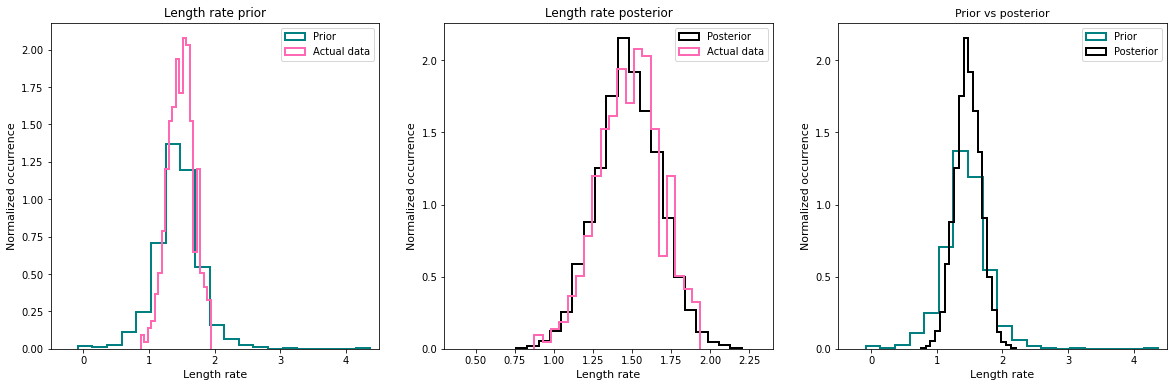

In [17]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6), sharex = False, sharey = False)

ax = axes[0]
ax.hist(length_normal_ppc, bins=20, label= "Prior", histtype='step', color='teal' , density = True, linewidth =2)
ax.hist(CrabAgePrediction_1['Length'], bins=20, label= "Actual data",
        histtype='step', color= 'hotpink', density = True, linewidth =2 )
ax.set_xlabel('Length rate', fontsize = 11)
ax.set_ylabel('Normalized occurrence', fontsize = 11)
ax.set_xlim([-0.5,4.5])
ax.set_title('Length rate prior')
ax.legend()

ax2 = axes[1]
ax2.hist(length_normal_fit, bins=20, label= "Posterior", histtype='step',color='black' ,density = True, linewidth =2)
ax2.hist(CrabAgePrediction_1['Length'], bins=20, label= "Actual data",
         histtype='step', color= 'hotpink', density = True, linewidth =2 )
ax2.set_xlabel('Length rate', fontsize = 11)
ax2.set_ylabel('Normalized occurrence', fontsize = 11)
ax2.set_xlim([0.3,2.4])
ax2.set_title('Length rate posterior')
ax2.legend()

ax3 = axes[2]
ax3.hist(length_normal_ppc, bins = 20, histtype = 'step', color = 'teal', label = 'Prior',
         linewidth= 2, density = True)
ax3.hist(length_normal_fit, bins = 20, density = True, label = 'Posterior', histtype='step',
         color = 'black', linewidth= 2)
ax3.set_title('Prior vs posterior', fontsize = 11)
ax3.set_xlim([-0.5,4.5])
ax3.set_xlabel('Length rate', fontsize = 11)
ax3.set_ylabel('Normalized occurrence', fontsize = 11)
ax3.legend()

plt.show()


The histograms are a comparision of the prior and the posterior generated mean value and standard deviation. The posterior data to be better fitted than the prior data. The posterior includes narrower interval lengths compared to the prior, which is a desirable and expected behavior. The peak in the actual data is not fully detected by the normal model.

The prior distribution exhibits a characteristic bell-shaped curve, while the histogram of the real data does not quite fit well with it. The prior data encompases wider data range, proposing also minus crab rates. Normal distribution model does seem to be able to model this phenomenon.



### Comparison of the prior and posterior - calculated parameters

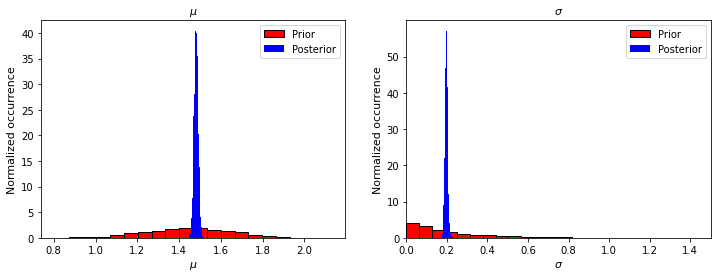

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = False)

ax = axes[0]
ax.hist(mu_normal_ppc, bins = 20, label = 'Prior', density = True, color = 'red', edgecolor = 'black')
ax.hist(mu_normal_fit, bins = 20, label = 'Posterior', density = True, color = 'blue')
ax.set_title('$\mu$', fontsize = 11)
ax.set_xlabel('$\mu$', fontsize = 11)
ax.set_ylabel('Normalized occurrence', fontsize = 11)
ax.legend()

ax2 = axes[1]
ax2.hist(sigma_normal_ppc, bins = 20, density = True, label = 'Prior', color = 'red', edgecolor = 'black')
ax2.hist(sigma_normal_fit, bins = 20, density = True, label = 'Posterior', color = 'blue')
ax2.set_title('$\sigma$',fontsize = 11)
ax2.set_xlim([0, 1.5])
ax2.set_xlabel('$\sigma$',fontsize = 11)
ax2.set_ylabel('Normalized occurrence',fontsize = 11)
ax2.legend()

plt.show()

Both values of $\mu$ are normally distributed around the set value of the mean (1.46). However, the average value of the posterior distribution is considerably more compact than that of the prior distribution, which extends to larger values. Additionally, the histogram of the posterior standard deviation appears to follow a normal distribution as well.

### Samples from joint posterior

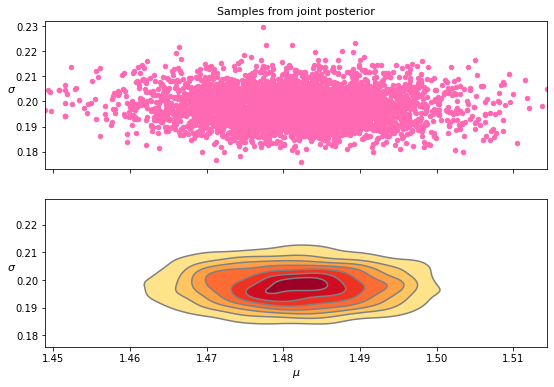

In [19]:
fig, axes = plt.subplots(2,1, figsize = (9, 6), sharex = True)

ax1 = axes[0]
ax1.scatter(mu_normal_fit, sigma_normal_fit, 20, color = 'hotpink')
ax1.set_ylabel(r'$\sigma$', rotation = 0, fontsize = 11)
ax1.set_title('Samples from joint posterior', fontsize = 11)

ax2 = axes[1]
az.plot_kde(mu_normal_fit, sigma_normal_fit, ax = ax2, contourf_kwargs = {'cmap': 'YlOrRd'})
ax2.set_ylabel(r'$\sigma$', rotation = 0, fontsize = 11)
ax2.set_xlabel(r'$\mu$', fontsize = 11)

plt.show()


The distribution is symmetrical, with the mean positioned at the peak of the distribution

# 6. Linear Model 2 - Prior predictive check

A linear model was introduced to improve the analysis of crab parameter rates. This model predicts the crab length rate using the shell weight rate a predictor. The mean value and standard deviation of the crab length rate were used to construct the alpha parameter. To centre the predictor, the mean value of the shell weight rate calculated from the actual data was subtracted.

In [20]:
CrabAgePrediction_1['c_Shell_Weight'] = (CrabAgePrediction_1['Shell Weight'] - CrabAgePrediction_1['Shell Weight'].mean())
CrabAgePrediction_1.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,c_Shell_Weight
25,M,1.2625,1.0000,0.3875,23.856104,7.696889,5.032036,8.079607,12,-1.964558
27,M,1.5250,1.2125,0.4375,35.280953,15.422128,8.419802,9.780577,12,-0.263588
34,M,1.5500,1.2250,0.4750,34.529691,15.464652,8.405627,10.064072,13,0.019907
65,M,1.3125,1.0375,0.4000,18.271253,7.370870,4.465046,6.236890,12,-3.807275
72,M,0.8750,0.6375,0.2125,6.080968,2.834950,1.318252,1.700970,13,-8.343195


In [21]:
linear_model2 = CmdStanModel(stan_file = 'linear_ppc.stan')

# liczba obserwacji Shell Weight = 1435
stan_data={'N': len(CrabAgePrediction_1['Shell Weight']),
           "Shell_Weight": np.linspace(CrabAgePrediction_1['c_Shell_Weight'].min(),
                                       CrabAgePrediction_1['c_Shell_Weight'].max(), num= 408)}

R = 1000
sim_linear = linear_model2.sample(data=stan_data, iter_sampling = R,
                                  refresh = R,
                                  iter_warmup = 0,
                                  chains = 1,
                                  fixed_param = True,
                                  seed = 31052023)

alpha_linear_ppc = sim_linear.stan_variable('alpha')
beta_linear_ppc = sim_linear.stan_variable('beta')
sigma_linear_ppc = sim_linear.stan_variable('sigma')
length_linear_pcc = sim_linear.stan_variable('length')


19:31:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


19:31:12 - cmdstanpy - INFO - CmdStan done processing.


### Plot histograms comparing prior and actual data

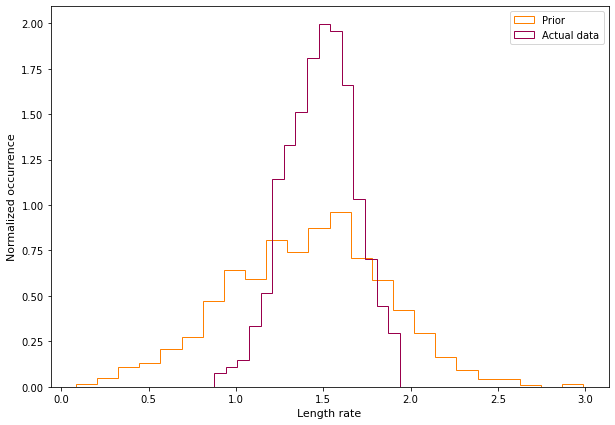

In [22]:
fig, axes = plt.subplots(1,1, figsize = (10,7), sharex = True)

length_mean_ppc = np.mean(length_linear_pcc, axis = 1)
plt.hist(length_mean_ppc, bins='auto', label= "Prior", histtype='step', density = True, color = '#ff8000')
plt.hist(CrabAgePrediction_1['Length'], bins='auto', label= "Actual data", histtype='step',
         color = '#99004c', density = True)
plt.xlabel('Length rate', fontsize = 11)
plt.ylabel('Normalized occurrence', fontsize = 11)
plt.legend()
plt.show()


Prior seems to fit the actual data quite well. Covers the whole range of data, but is unable to detect the highest peak.

### Comparision of prior outcomes

Text(0, 0.5, 'Simulated Length rate')

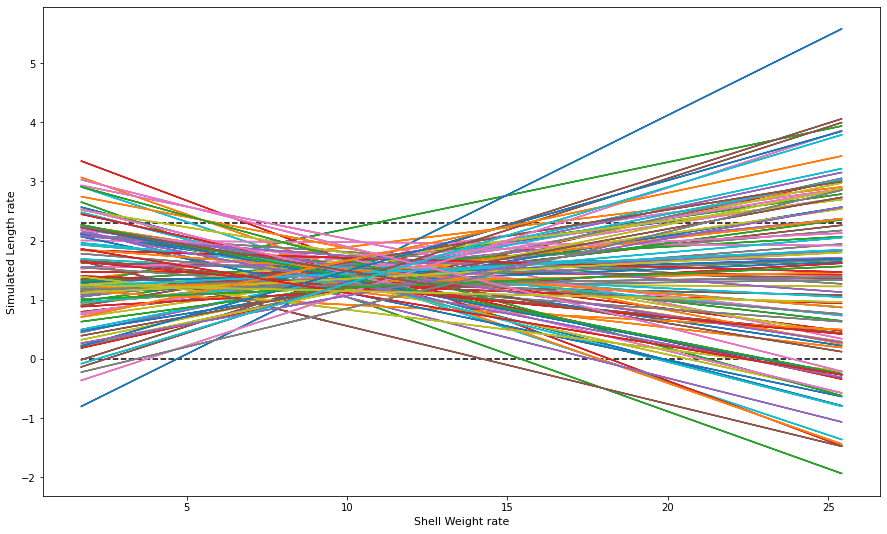

In [23]:
fig, axes = plt.subplots(1,1, figsize = (15,9))
axes.hlines([0, 2.296], xmin = CrabAgePrediction_1['Shell Weight'].min(),
            xmax = CrabAgePrediction_1['Shell Weight'].max(), linestyle = '--', color = 'black')

for i in range(100):
    axes.plot(CrabAgePrediction_1['Shell Weight'],
              alpha_linear_ppc[i] + beta_linear_ppc[i]*CrabAgePrediction_1['c_Shell_Weight'])

axes.set_xlabel('Shell Weight rate', fontsize = 11)
axes.set_ylabel('Simulated Length rate', fontsize = 11)

Value 2. 296 represents the length of the longest crab of this species in the culture.
Upon closer examination of the relationship between weight and length in our model, we have discovered some discrepancies. Specifically, we have encountered negative values for crab length, which is not physically possible. To address this issue and ensure the model aligns with the nature of the data, we need to introduce additional parameters to constrain the length values to be positive and within a reasonable range.

One approach to address this is by incorporating a logarithmic distribution. This distribution is based on a logarithmic scale, guaranteeing positive values at all times. By applying a logarithmic transformation to the length variable, we can capture the relationship between Shell Weight  and length in a more accurate and meaningful way.

# 7. Linear model 2 - Posterior analysis

A linear model was introduced to improve the analysis of crab parameter rates. This model predicts the crab length rate using the shell weight rate a predictor. The mean value and standard deviation of the crab length rate were used to construct the alpha parameter. To centre the predictor, the mean value of the shell weight rate calculated from the actual data was subtracted.

In [24]:
linear_fit_model2 = CmdStanModel(stan_file = 'linear_fit.stan')

stan_data={'N': len(CrabAgePrediction_1["Shell Weight"]),
           "Shell_Weight": CrabAgePrediction_1["c_Shell_Weight"],
           "lengths":CrabAgePrediction_1["Length"]}

R = 1000
sim_fit_2 = linear_fit_model2.sample(data=stan_data, iter_sampling = R,
                                     iter_warmup = 1000,
                                     chains = 4,
                                     fixed_param = False,
                                     seed = 31052023)

alpha_linear_fit = sim_fit_2.stan_variable('alpha')
beta_linear_fit = sim_fit_2.stan_variable('beta')
sigma_linear_fit = sim_fit_2.stan_variable('sigma')
mu_linear_fit = sim_fit_2.stan_variable('mu')
length_linear_fit = sim_fit_2.stan_variable('length')

19:31:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:31:19 - cmdstanpy - INFO - CmdStan done processing.
19:31:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/Project_DA/linear_fit.stan', line 22, column 4 to column 31)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/Project_DA/linear_fit.stan', line 22, column 4 to column 31)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/Project_DA/linear_fit.stan', line 22, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!


After compilation of the linear distribution model with fitting, there were no sampling errors.

In [25]:
sim_fit_2.diagnose()

'Processing csv files: /tmp/tmpjpb0fd04/linear_fitl_n6a4mc/linear_fit-20230709193118_1.csv, /tmp/tmpjpb0fd04/linear_fitl_n6a4mc/linear_fit-20230709193118_2.csv, /tmp/tmpjpb0fd04/linear_fitl_n6a4mc/linear_fit-20230709193118_3.csv, /tmp/tmpjpb0fd04/linear_fitl_n6a4mc/linear_fit-20230709193118_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [26]:
az.summary(sim_fit_2,var_names=['alpha','beta','sigma','mu','length'], round_to=5,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,1.48163,0.00535,1.47192,1.49165
beta,0.04399,0.00143,0.04119,0.04666
sigma,0.10720,0.00370,0.10012,0.11382
mu[0],1.39521,0.00607,1.38381,1.40653
mu[1],1.47003,0.00537,1.46007,1.48000
...,...,...,...,...
length[403],1.91303,0.10550,1.71208,2.10433
length[404],1.30627,0.10625,1.11943,1.51746
length[405],1.45804,0.11059,1.24389,1.66027
length[406],1.41432,0.10688,1.22022,1.62393


The provided table summarizes the posterior distributions for the model parameters ($\alpha$, $\beta$, $\sigma$) and the simulated lengths. The mean values and highest density intervals (HDIs) give insights into the central tendencies and plausible ranges of these quantities. The results indicate that the intercept term ($\alpha$) has a moderate positive effect on the simulated lengths, while the coefficient for the predictor variable ($\beta$) suggests a small positive effect. The standard deviation ($\sigma$) represents the variability of the simulated lengths around the predictions. The mu values show the predicted lengths for each observation, while the length values represent the simulated lengths.

### Comparision of posterior outcomes

Text(0, 0.5, 'Simulated Length rate')

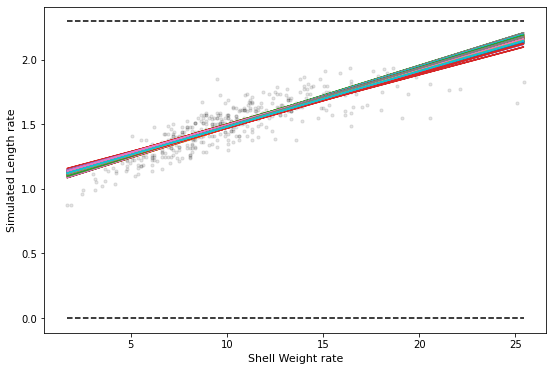

In [27]:
fig, axes = plt.subplots(1,1, figsize = (9,6))

axes.hlines([0, 2.296], xmin = CrabAgePrediction_1['Shell Weight'].min(),
            xmax = CrabAgePrediction_1['Shell Weight'].max(), linestyle = '--', color = 'black')

for i in range(100):
    axes.plot(CrabAgePrediction_1['Shell Weight'],
              alpha_linear_fit[i] + beta_linear_fit[i]*CrabAgePrediction_1['c_Shell_Weight'])

axes.scatter(CrabAgePrediction_1['Shell Weight'], CrabAgePrediction_1['Length'],
             color = 'black', alpha = 0.1, s=10)

axes.set_xlabel('Shell Weight rate', fontsize = 11)
axes.set_ylabel('Simulated Length rate', fontsize = 11)

After adding the logarithm to our model, the model makes more sense. Now the values are not negative.

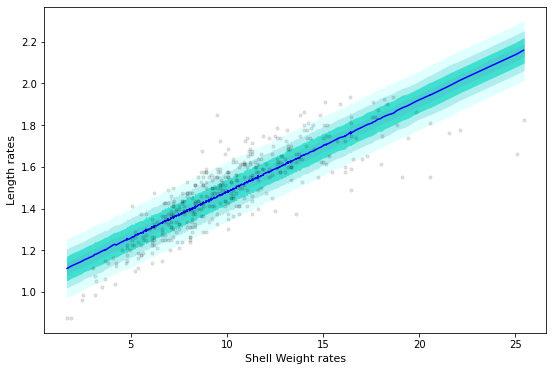

In [28]:
fig, axes = plt.subplots(1, 1, figsize = (9, 6))

x_axis = np.array(CrabAgePrediction_1['Shell Weight'])

axes = ribbon_plot(x_axis, length_linear_fit, axes, supress_warning = True)
axes.scatter(CrabAgePrediction_1['Shell Weight'],CrabAgePrediction_1['Length'],
             color='black', alpha = 0.1, s=10)

axes.set_xlabel('Shell Weight rates', fontsize = 11)
axes.set_ylabel('Length rates', fontsize = 11)
plt.show()

The darkest blue line is a median.

Charts $\alpha$ and $\beta$ show that both parameters are reasonably compact and have a normal distribution.

### Comparison of the prior and posterior - calculated parameters alpha and beta

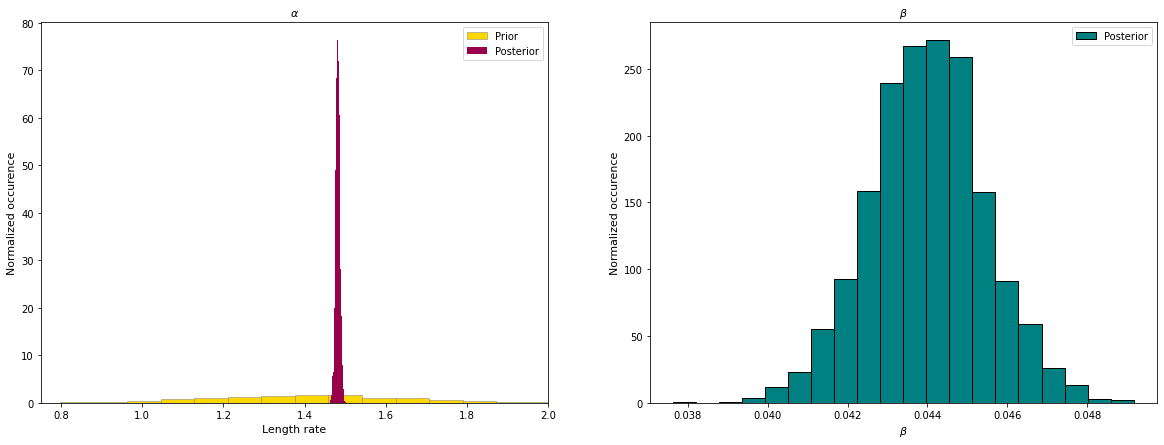

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

ax = axes[0]
ax.hist(alpha_linear_ppc, bins = 20, label = 'Prior',density = True, color = 'gold', edgecolor='grey', linewidth = 0.5)
ax.hist(alpha_linear_fit, bins = 20, label = 'Posterior',color = '#99004c',density = True)
ax.set_xlabel('Length rate', fontsize = 11)
ax.set_ylabel('Normalized occurence', fontsize = 11)
ax.set_title(r'$\alpha$', fontsize = 11)
ax.set_xlim([0.75, 2])
ax.legend()

ax2 = axes[1]
# ax2.hist(beta_linear_ppc, bins = 20, label = 'Prior', density = True, color = 'gold', edgecolor = 'grey', linewidth = 0.5)
ax2.hist(beta_linear_fit, bins = 20, density = True, label = 'Posterior',color = 'teal', edgecolor='black' )
ax2.set_title(r'$\beta$', fontsize = 11)
ax2.set_xlabel(r'$\beta$', fontsize = 11)
ax2.set_ylabel('Normalized occurence', fontsize = 11)
ax2.legend()

plt.show()


Both $\alpha$ and $\beta$ in the posterior distribution exhibit a normal distribution pattern. They attain higher values compared to the posterior parameters. The posterior values are more succinct and follow the prescribed parameters within the model.

## Prediction uncertainity for all age

### Adding higher orders
Our data for the entire dataset expresses much more curvature than the linear model can capture. Lets extend our model by adding quadratic term i.e.


Our data for the entire dataset expresses much more curvature than the linear model can capture.
Lets extend our model by adding quadratic term i.e.
$$
\mu_i = \alpha+\beta_1\cdot\mathrm{Shell Weight}_i+\beta_2\cdot\mathrm{Shell Weight}_i^2
$$

In [30]:
CrabAgePrediction_2 = CrabAgePrediction.drop(CrabAgePrediction[(CrabAgePrediction['Sex'] == 'F') | (CrabAgePrediction['Sex'] == 'I')].index)

COUNT  = CrabAgePrediction_2.loc[CrabAgePrediction['Sex'] == 'M'].shape[0]
print(COUNT)
CrabAgePrediction_2.head()

1435


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
7,M,1.3250,1.0125,0.3750,23.572609,9.979024,5.301356,7.158249,10
10,M,0.8250,0.5375,0.1875,3.246018,1.275727,0.751262,0.992232,6
12,M,0.8625,0.6375,0.2250,5.684075,2.664853,0.836310,1.786018,9
16,M,1.6000,1.3125,0.4500,37.237068,13.792032,8.490675,11.552421,10


The analysis was conducted for each age group, only including male individuals.

In [31]:
CrabAgePrediction_2['Length'].describe()

count    1435.000000
mean        1.403946
std         0.256181
min         0.387500
25%         1.262500
50%         1.450000
75%         1.575000
max         1.950000
Name: Length, dtype: float64

### Standarization of variables 

In [32]:
CrabAgePrediction_2['c_ShellWeight'] = CrabAgePrediction_2['Shell Weight'] - CrabAgePrediction_2['Shell Weight'].mean()
CrabAgePrediction_2['s_ShellWeight'] = CrabAgePrediction_2['c_ShellWeight']/CrabAgePrediction_2['Shell Weight'].std()
CrabAgePrediction_2.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,c_ShellWeight,s_ShellWeight
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,-6.434398,-1.739398
7,M,1.3250,1.0125,0.3750,23.572609,9.979024,5.301356,7.158249,10,-0.835372,-0.225824
10,M,0.8250,0.5375,0.1875,3.246018,1.275727,0.751262,0.992232,6,-7.001388,-1.892671
12,M,0.8625,0.6375,0.2250,5.684075,2.664853,0.836310,1.786018,9,-6.207602,-1.678088
16,M,1.6000,1.3125,0.4500,37.237068,13.792032,8.490675,11.552421,10,3.558801,0.962043


We can see how certain coefficient is for the Shell Weight is characteristic from the sample or not. Using standardized or the central variables doesn't change our model will just change the values of our predictor coefficient. 

In [33]:
linear_fit_alldata = CmdStanModel(stan_file = 'length_fit_alldata.stan')

stan_data = dict(N=len(CrabAgePrediction_2), shell_weight = CrabAgePrediction_2.s_ShellWeight.values,
                 lengths = CrabAgePrediction_2.Length.values)
# R = 1000
sim_fit_3 = linear_fit_alldata.sample(data=stan_data, seed = 31052023)

19:31:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 


19:31:38 - cmdstanpy - INFO - CmdStan done processing.


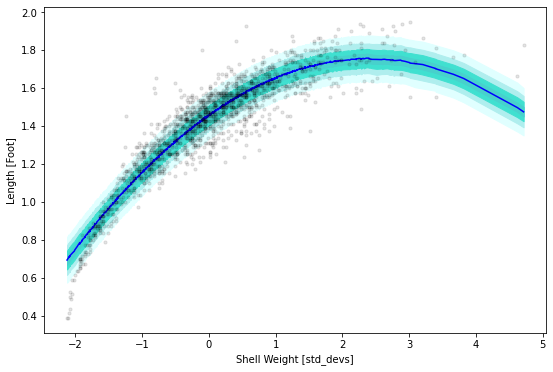

In [34]:
length_pred = sim_fit_3.stan_variable("length_generated")
beta_2 = sim_fit_3.stan_variable('length_generated')

fig,axes = plt.subplots(1,1,figsize=(9,6))
axes = ribbon_plot(CrabAgePrediction_2.s_ShellWeight.values, length_pred, axes, supress_warning=True)
axes.scatter(CrabAgePrediction_2.s_ShellWeight, CrabAgePrediction_2.Length, color='black',alpha=0.1, s =10)
axes.set_xlabel('Shell Weight [std_devs]')
axes.set_ylabel('Length [Foot]')
plt.show()


The model produced satisfactory results, providing a foundation for further exploration of the data. In the subsequent step, higher-order predictors were incorporated to enhance the analysis, and the actual data points were visually depicted on the plotted graph. 

In [35]:
az.summary(sim_fit_3,var_names=['alpha','beta_1','beta_2','sigma'],round_to=4,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,1.4558,0.0029,1.4502,1.4611
beta_1,0.2489,0.0026,0.2443,0.2542
beta_2,-0.0519,0.0016,-0.0546,-0.0489
sigma,0.0937,0.0017,0.0904,0.0967


## Creating a design matrix

In [36]:
CrabAgePrediction_2.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,c_ShellWeight,s_ShellWeight
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,-6.434398,-1.739398
7,M,1.3250,1.0125,0.3750,23.572609,9.979024,5.301356,7.158249,10,-0.835372,-0.225824
10,M,0.8250,0.5375,0.1875,3.246018,1.275727,0.751262,0.992232,6,-7.001388,-1.892671
12,M,0.8625,0.6375,0.2250,5.684075,2.664853,0.836310,1.786018,9,-6.207602,-1.678088
16,M,1.6000,1.3125,0.4500,37.237068,13.792032,8.490675,11.552421,10,3.558801,0.962043


In [37]:
CrabAgePrediction_2['s_ShellWeight^2'] = CrabAgePrediction_2['s_ShellWeight']**2
CrabAgePrediction_2['s_ShellWeight^3'] = CrabAgePrediction_2['s_ShellWeight']**3
CrabAgePrediction_2.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,c_ShellWeight,s_ShellWeight,s_ShellWeight^2,s_ShellWeight^3
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,-6.434398,-1.739398,3.025504,-5.262555
7,M,1.3250,1.0125,0.3750,23.572609,9.979024,5.301356,7.158249,10,-0.835372,-0.225824,0.050997,-0.011516
10,M,0.8250,0.5375,0.1875,3.246018,1.275727,0.751262,0.992232,6,-7.001388,-1.892671,3.582203,-6.779932
12,M,0.8625,0.6375,0.2250,5.684075,2.664853,0.836310,1.786018,9,-6.207602,-1.678088,2.815981,-4.725464
16,M,1.6000,1.3125,0.4500,37.237068,13.792032,8.490675,11.552421,10,3.558801,0.962043,0.925527,0.890397


In [38]:
X=CrabAgePrediction_2.iloc[:,-3:].values

Incorporating the third power of the standardized weight as additional predictors, a design matrix is constructed. The design matrix is then multiplied by a vector of parameters, with sizes that complement each other, transforming our model into a traditional form of a linear model.Incorporating the third power of the standardized weight as additional predictors, a design matrix is constructed. The design matrix is then multiplied by a vector of parameters, with sizes that complement each other, transforming our model into a traditional form of a linear model.

This model that allows to submit any kind of design matrix form our model.

In [39]:
linear_fit2_alldata = CmdStanModel(stan_file = 'length_fit2_alldata.stan')

stan_data=dict(N=len(CrabAgePrediction_2), K=3, X=X,
               lengths=CrabAgePrediction_2.Length.values)
sim_fit_4 = linear_fit2_alldata.sample(data=stan_data, seed = 31052023) 

19:31:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |███

19:31:47 - cmdstanpy - INFO - CmdStan done processing.


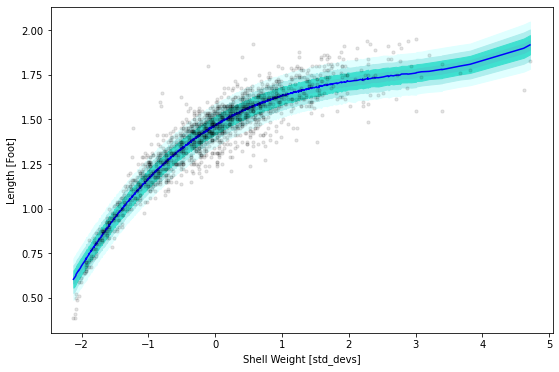

In [40]:
Lenght_pred=sim_fit_4.stan_variable('Length')

fig, axes = plt.subplots(1, 1, figsize=(9, 6))
axes=ribbon_plot(CrabAgePrediction_2.s_ShellWeight.values, Lenght_pred, axes, supress_warning=True)
axes.scatter(CrabAgePrediction_2.s_ShellWeight, CrabAgePrediction_2.Length, color='black', alpha=0.1, s=10)
axes.set_xlabel('Shell Weight [std_devs]')
axes.set_ylabel('Length [Foot]')
plt.show()

Generally, we improve on our predicitons, our model even more wiggling of this situation,  we have fitted cubic model.

In [41]:
az.summary(sim_fit_4,var_names=['alpha','beta','sigma'], round_to=3, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,1.467,0.003,1.462,1.474
beta[0],0.224,0.003,0.218,0.230
beta[1],-0.068,0.002,-0.072,-0.064
beta[2],0.009,0.001,0.007,0.010
sigma,0.090,0.002,0.087,0.093


# 8. Model comaprison

In [42]:
fit_normal_id = az.from_cmdstanpy(posterior = sim_fit, log_likelihood = 'log_lik',
                                  posterior_predictive = 'length',
                                  observed_data ={'lengths':CrabAgePrediction_1['Length']} )

fit_linear_id = az.from_cmdstanpy(posterior=sim_fit_2, log_likelihood = 'log_lik',
                                  posterior_predictive='length',
                                  observed_data={'lengths':CrabAgePrediction_1["Length"]})

compare_dict = {'Normal model': fit_normal_id,'Linear model': fit_linear_id}

### `PSIS-LOOCV` comparison
* Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time.

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Linear model,0,330.358546,5.401234,0.000000,0.975289,18.833218,0.000000,False,log
Normal model,1,81.136248,1.885152,249.222298,0.024711,13.818396,20.104315,False,log


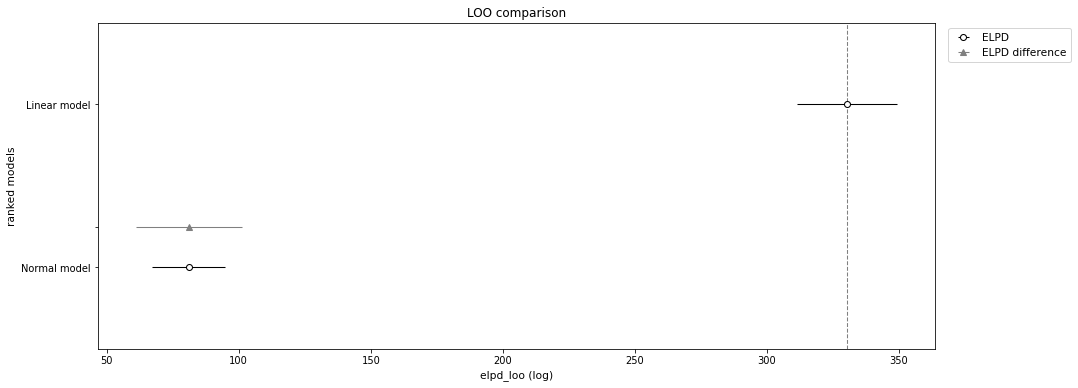

In [43]:
model_compare_loo = az.compare(compare_dict, ic="loo", method="stacking", scale="log")

fig, ax = plt.subplots(figsize=(15, 6))

display(model_compare_loo.head())

az.plot_compare(model_compare_loo, ax=ax)
plt.title('LOO comparison')

plt.show()

Comparison of normal and linear model results on the basis of the obtained LOO criterion indices:
- Linear model has a "rank" of 0, indicating that it is better than Normal model, which has a rank of 1

- Linear model has a LOO value of 330.365372, while Normal model has a LOO value of 81.138618

- "p_loo" represents the estimated value of the LOO estimate along with the standard error. For Linear model, it is 5.394408, and for Normal model, it is 1.882782

- "d_loo" shows the difference in LOO between Linear model and Normal model. In this case, it is 249.226754, indicating that Linear model has a lower LOO by that amount compared to Normal model

- "weight" represents the weight assigned to each model. For Linear model, the weight is 0.975292, and for Normal model, it is 0.024708. A higher weight implies a higher probability that the model is well-fitted to the data

- "se" indicates the standard error for the model weights. For Linear model, it is 18.831989, and for Normal model, it is 13.818206

- "dse" represents the standard error for the difference between the models. For Linear model, it is 0.00000, and for Normal model, it is 20.103261

- "warning" indicates whether any warnings occurred during the calculations. For Linear model and Normal model, the value is False

- "loo_scale" specifies the scale used for models and it is "log" for both models

On the basis of the LOO criterion, the linear model can be said to have a lower rank (meaning the best model). Standard error of the LOO difference criterion (dse) - tells you that the difference between the models is small. Inferring from the results, the two models do not quite overlap.

### `WAIC` comparision
* Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


              rank   elpd_waic    p_waic   elpd_diff    weight         se  \
Linear model     0  330.377740  5.382040    0.000000  0.975298  18.826616   
Normal model     1   81.139095  1.882304  249.238644  0.024702  13.818107   

                    dse  warning scale  
Linear model   0.000000     True   log  
Normal model  20.098289    False   log  


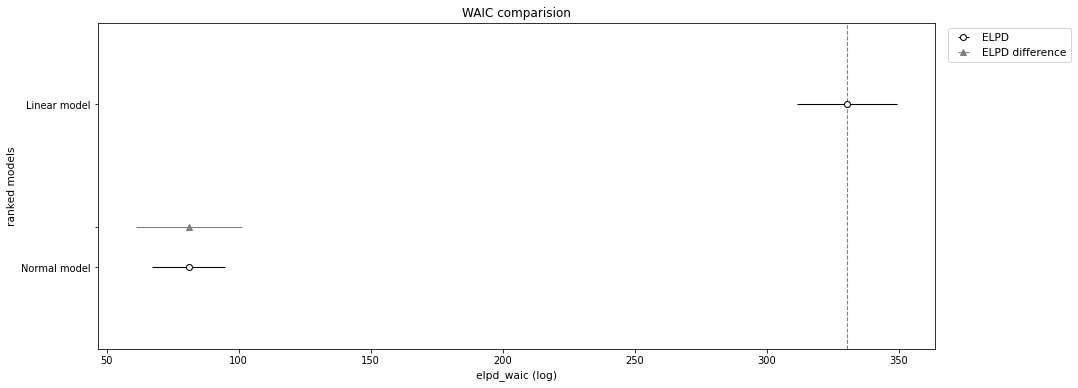

In [44]:
model_compare_waic = az.compare(compare_dict=compare_dict, ic='waic')

fig, ax = plt.subplots(figsize=(15, 6))

print(model_compare_waic.head())

az.plot_compare(model_compare_waic,ax =ax)
plt.title('WAIC comparision')

plt.show()


Comparison of normal and linear model results on the basis of the obtained WAIC criterion indices:
- Linear model has a "rank" of 0, indicating that it is better than Normal model, which has a rank of 1

- Linear model has a WAIC value of 330.377740, while Normal model has a WAIC value of 81.139095

- "p_waic" represents the estimated value of the WAIC estimate along with the standard error. For Linear model, it is 5.382040, and for Normal model, it is 1.882304

- "d_waic" shows the difference in WAIC between Linear model and Normal model. In this case, it is 249.238644, indicating that Linear model has a lower WAIC by that amount compared to Normal model

- "weight" represents the weight assigned to each model. For Linear model, the weight is 0.975298, and for Normal model, it is 0.024702. A higher weight implies a higher probability that the model is well-fitted to the data

- "se" indicates the standard error for the model weights. For Linear model, it is 18.826616, and for Normal model, it is 13.818107

- "dse" represents the standard error for the difference between the models For Linear model, it is 0.00000, and for Normal model, it is 20.098289

- "warning" indicates whether any warnings occurred during the calculations. For Linear model, the value is True, and for Normal model, it is False.

- "waic_scale" scale used for both models it is "log"

On the basis of the WAIC criterion, the linear model can be said to have a lower rank (meaning the best model). Standard error of the WAIC difference criterion (dse) - tells you that the difference between the models is small. In contrast, the linear model as opposed to the normal model in the WAIC criterion encountered warnings. Inferring from the results, the two models do not quite overlap.

Considering the two models , the first model provides a general understanding of the overall data distribution and captures its characteristics, while the second model specifically focuses on the relationship between the crab length rate and the shell weight rate. By incorporating additional parameters such as the intercept and regression coefficients, the second model allows for a more detailed analysis of the specific influence of the shell weight rate on the crab length rate.